In [145]:
import h5py
import pandas as pd
from raster_maker import SonataWriter
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy

In [146]:
df = pd.read_csv('Connections.csv')

In [147]:
p_delta = 0.1 # change p_delta of the nodes to 100% modulation
num_cells = int(p_delta * df[(df['Source Population']=='exc_stim')&(df.Name.str.contains('dend'))]['Node ID'].nunique())
cells_to_change = np.random.choice(df[(df['Source Population']=='exc_stim')&
                                      (df.Name.str.contains('dend'))]['Node ID'].unique(),
                                   num_cells,
                                   replace=False)

In [149]:
depth_of_mod = 1
freq = 64
phase= 0#2*np.pi/3
tsim = 400 # seconds
t = np.arange(0,tsim,.001)

mod_trace = depth_of_mod*(np.sin((2 * np.pi * freq * t ) - phase) + 1) + (1-depth_of_mod)

#numbPoints = scipy.stats.poisson(rate_temp/1000).rvs()#Poisson number of points
#simSpks=np.where(numbPoints>0)[0]

In [150]:
f = h5py.File('exc_stim_spikes.h5','r')

In [151]:
mask = np.isin(f['spikes']['exc_stim']['node_ids'][:], cells_to_change)
anti_mask = ~mask

In [152]:
old_timestamps = f['spikes']['exc_stim']['timestamps'][anti_mask]
old_nodeids = f['spikes']['exc_stim']['node_ids'][anti_mask]

In [153]:
fr_df = pd.DataFrame(np.concatenate((f['spikes']['exc_stim']['timestamps'][mask].reshape(-1,1),
                                     f['spikes']['exc_stim']['node_ids'][mask].reshape(-1,1)),axis=1),
             columns = ['timestamps','node_ids'])
fr_df = (fr_df.groupby('node_ids')['timestamps'].count()/tsim).reset_index()

In [154]:
fr_df.head()

,node_ids,timestamps
0,14.0,2.2650
1,17.0,5.6725
2,28.0,1.2175
3,32.0,10.4400
4,38.0,6.1325


In [155]:
ts = []
nid = []
for n in fr_df['node_ids']:
    fr = fr_df.loc[fr_df.node_ids==n,'timestamps'].values
    #import pdb; pdb.set_trace()
    numbPoints = scipy.stats.poisson(fr*mod_trace/1000).rvs()
    ts.append(np.where(numbPoints>0)[0])
    nid.append(np.repeat(n,np.where(numbPoints>0)[0].shape[0]))

In [156]:
new_timestamps = np.concatenate(ts).ravel()
new_nodeids = np.concatenate(nid).ravel()

In [157]:
timestamps = np.concatenate((old_timestamps,new_timestamps)).astype(int)
node_ids = np.concatenate((old_nodeids,new_nodeids)).astype(int)

In [158]:
!rm exc_stim_spikes2.h5

In [159]:
#f = h5py.File("exc_stim_spikes2.h5", "w")
#f.create_dataset('spikes/exc_stim/timestamps', timestamps, chunks=True)
#f.create_dataset('spikes/exc_stim/node_ids', node_ids, chunks=True)
#f.close()

In [160]:
fname = 'exc_stim_spikes2.h5'
writer = SonataWriter(fname, ["spikes", "exc_stim"], ["timestamps", "node_ids"], [np.float, np.int])

for i in np.unique(node_ids):
    simSpks = timestamps[node_ids==i]
    writer.append_repeat("node_ids", int(i), len(simSpks))
    writer.append_ds(simSpks, "timestamps")
    
writer.close()

In [161]:
# make sin wave
sw = np.sin(2*np.pi*(64/1000)*np.arange(0,tsim*1000,1))
pks = ss.find_peaks(sw)[0]

prox_spk = np.zeros((pks[::5].shape[0],78))
ts = timestamps

for c,i in enumerate(pks[::5]):
    h = np.histogram(ts[(ts>i) & (ts<i+78)], bins = np.arange(i,i+79))
    prox_spk[c,:] = h[0]

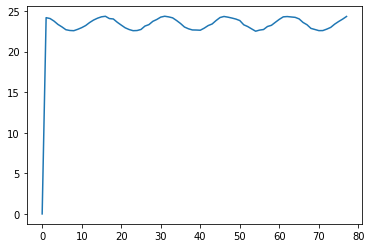

In [162]:
plt.plot(np.mean(prox_spk,axis=0))

(0, 100)

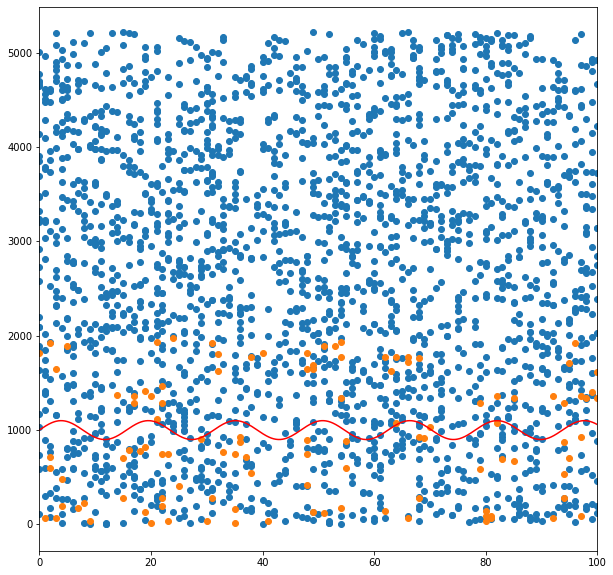

In [163]:
plt.figure(figsize=(10,10))
plt.scatter(old_timestamps,old_nodeids)
plt.scatter(new_timestamps,new_nodeids)
plt.plot(np.arange(0,1000,.1), 100*np.sin(2*np.pi*(64/1000)*np.arange(0,1000,.1))+1000,color='r')
plt.xlim(0,100)

In [17]:
f = h5py.File('./exc_stim_spikes.h5','r')
g = h5py.File('./prox_inh_stim_spikes.h5','r')

(array([18., 30., 24., ..., 19., 27., 31.]),
 array([    0,     1,     2, ..., 99997, 99998, 99999]),
 <a list of 99999 Patch objects>)

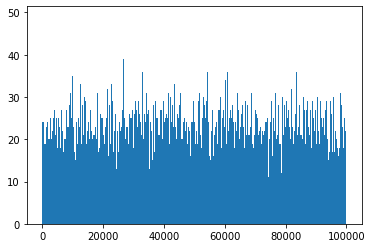

In [24]:
plt.hist(f['spikes']['exc_stim']['timestamps'][:],bins=np.arange(0,100000,1))

In [ ]:
plt.hist(g['spikes']['exc_stim']['timestamps'][:],bins=np.arange(0,100000,1))

(0, 100)

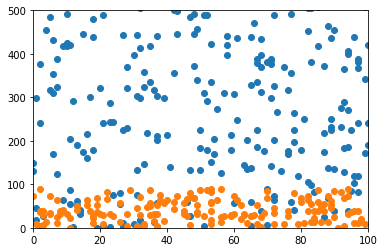

In [22]:
plt.scatter(f['spikes']['exc_stim']['timestamps'][:],
            f['spikes']['exc_stim']['node_ids'][:])
plt.scatter(g['spikes']['prox_inh_stim']['timestamps'][:],
            g['spikes']['prox_inh_stim']['node_ids'][:])
plt.ylim(0,500)
plt.xlim(0,100)

In [65]:
f = h5py.File('./output_64Hz_soma_0deg_exc_30p/v_report.h5','r')
g = h5py.File('./output_64Hz_soma_180deg_exc_30p/v_report.h5','r')

In [64]:
f['spikes']['biophysical']['timestamps'][:].shape[0]/100, g['spikes']['biophysical']['timestamps'][:].shape[0]/100

(5.73, 7.34)

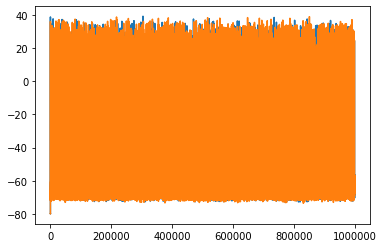

In [66]:
plt.plot(f['report']['biophysical']['data'][:,0])
plt.plot(g['report']['biophysical']['data'][:,0])